# References

https://www.kaggle.com/humamfauzi/btc-price-prediction-using-lstm

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.analyticsvidhya.com/blog/2021/05/bitcoin-price-prediction-using-recurrent-neural-networks-and-lstm/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.config.list_logical_devices('GPU')

2021-08-13 13:19:00.662186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-13 13:19:01.150018: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-13 13:19:01.150041: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ironfist): /proc/driver/nvidia/version does not exist
2021-08-13 13:19:01.164161: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-13 13:19:01.260254: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2899885000 Hz
2021-08-13 13:19:01.261401: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3dfc000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-13 13:1

[]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation

In [4]:
# Change...
pair = 'BTCUSDT'

# interval used to compute indicators and backtest analysis
# valid intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
interval = '1H'

In [5]:
from binance_utils import init
from trade_utils import get_data

client = init()
data = get_data(client, pair, interval)

In [6]:
# Last column must be the target
COLUMNS = ['ClosePrice']
N_STEPS = 30
N_FEATURES = len(COLUMNS)

data = data[COLUMNS].copy()

In [7]:
from machine_learning_utils import split_sequence

sc = MinMaxScaler()
data_scaled = sc.fit_transform(data)

In [8]:
#close_price = np.array(data['ClosePrice']).reshape(-1,1)
#close_price = np.array(data.iloc[:,-1]).reshape(-1,1)
#close_price

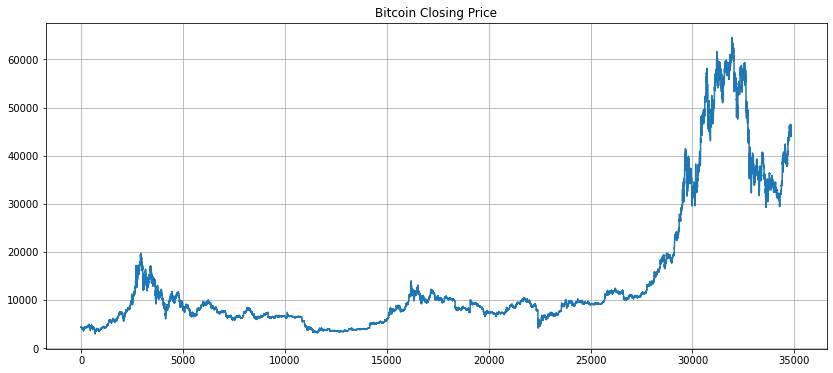

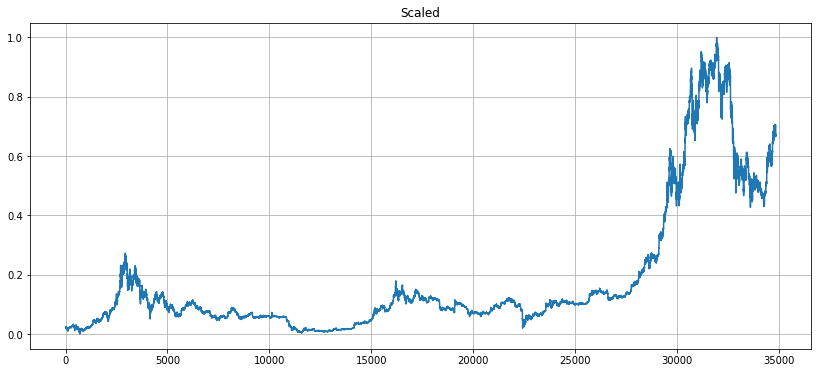

In [9]:
close_price = np.array(data['ClosePrice']).reshape(-1,1)
plt.figure(figsize=(14,6))
plt.title("Bitcoin Closing Price")
plt.grid()
plt.plot(close_price)

# Last column from data_scaled
close_price_scaled = data_scaled[:,-1]
plt.figure(figsize=(14,6))
plt.title("Scaled")
plt.grid()
plt.plot(close_price_scaled)

In [10]:
from machine_learning_utils import split_sequence

X, y = split_sequence(data_scaled, N_STEPS)
print(X.shape, y.shape)

(34820, 30, 1) (34820,)


In [11]:
# Obtain the features and target for the 'train_data' and 'test_data' without shuffling
# shuffle is not correct to use in time-series analysis because the order of the data is mandatory
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, shuffle=False)

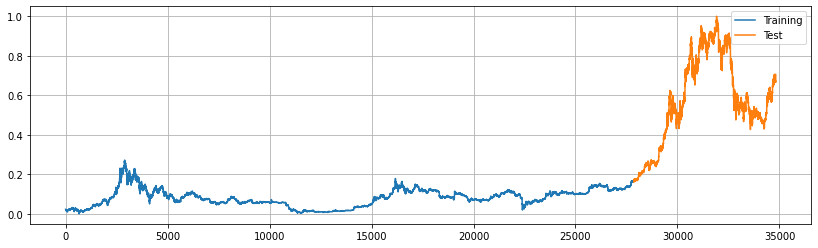

In [12]:
plt.figure(figsize=(14,4))
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train), len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

## Prepare X for LSTM

In [13]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], N_FEATURES))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], N_FEATURES))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

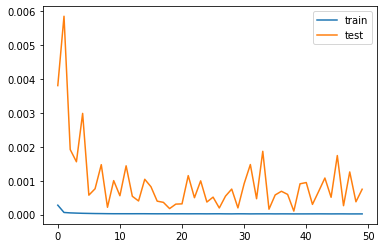

CPU times: user 31min 36s, sys: 2min 6s, total: 33min 43s
Wall time: 14min 13s


In [14]:
%%time
# define model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences=True, input_shape=(N_STEPS, N_FEATURES)))
model.add(Dropout(0.2))

# Intermediate LSTM layer
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

# LSTM layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(units = 1))

print(model.summary())

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting to the training set
history = model.fit(X_train, y_train, epochs=50, batch_size=168, validation_data=(X_test, y_test))

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
y_pred = model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)

Text(0, 0.5, 'Price')

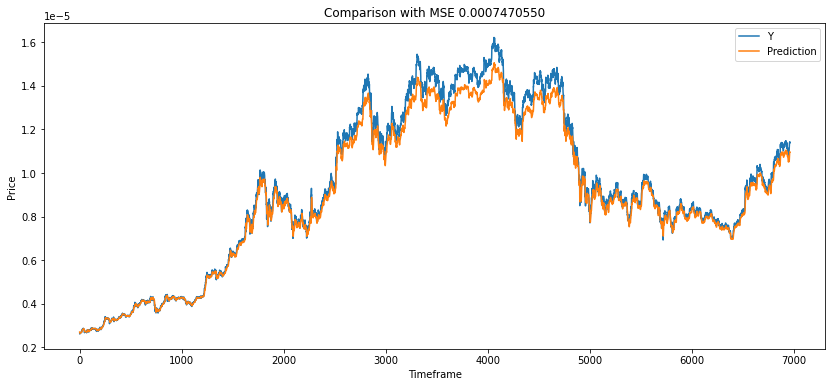

In [16]:
# scale used in last column (target)
scale_target = sc.scale_[-1]

plt.figure(figsize=(14,6))
plt.plot(y_test * scale_target)
plt.plot(y_pred * scale_target)
plt.title("Comparison with MSE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")